<a href="https://colab.research.google.com/github/jhchang/Sentiment-Analysis-on-Arabic-Text/blob/main/arabic-dialect-code-switch-profiler/04_transformer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Arabic Dialect Classification with Transformer Models

In this notebook, we fine-tune **state-of-the-art Arabic transformer models** for the task of **Arabic dialect identification** using the MADAR Corpus. This dataset includes short text samples labeled across **26 distinct Arabic dialects and MSA**, making it a challenging multiclass classification problem due to the high degree of lexical and syntactic similarity between dialects.

---

### 🎯 Objective

Our goal is to improve upon traditional baselines (TF-IDF, MLP, Naive Bayes, SVM, CNN, BiLSTM) by leveraging **pretrained transformer models** that have been trained on large Arabic corpora. These models provide deep contextual understanding, especially valuable in:

* ✅ Morphologically rich language like Arabic
* ✅ Dialects with overlapping vocabulary
* ✅ Short text sequences (≤16 tokens per sample)

---

### ⚙️ Why Use Transformers?

Unlike traditional deep learning models, transformer-based architectures:

* Use **multi-headed self-attention** to capture long-range and nuanced dependencies
* Do not rely on sequential memory (unlike LSTMs or RNNs) thus capturing long-range dependencies
* Offer **state-of-the-art results** on a variety of NLP tasks in Arabic, especially dialect classification
* Pays **context-aware attention** to all words in the input
* Provides **strong generalization** from limited data

We focus on fine-tuning pretrained Arabic models such as:

| Model         | Strength                                                | HF Model ID                        |
| ------------- | ------------------------------------------------------- | ---------------------------------- |
| **AraBERT**   | General-purpose Arabic (MSA + dialects) from news & web | `aubmindlab/bert-base-arabertv02`  |
| **MARBERT**   | Dialect-heavy, trained on 1B+ Arabic tweets             | `UBC-NLP/MARBERT`                  |
| **CAMeLBERT** | Focused on dialect classification and morphology        | `CAMeL-Lab/bert-base-camelbert-da` |

---

### 🧪 In This Notebook

* ✅ Load and preprocess the MADAR dataset

* ✅ Tokenize with the appropriate Hugging Face tokenizer

* ✅ Fine-tune a transformer model on the training data

* ✅ Evaluate performance using validation accuracy and confusion matrix

* ✅ Compare results with previous non-transformer models

---

## 🇸🇦 Relevance to Saudi Vision 2030

Accurate Arabic dialect classification supports several **Vision 2030** goals related to digital transformation, AI, and cultural preservation. In particular, it enables:

* ✅ **Intelligent virtual assistants** and **chatbots** that understand local dialects, improving user engagement in government and private sector services.
* ✅ **Voice recognition systems** adapted to regional Arabic varieties, essential for smart city initiatives and inclusive AI.
* ✅ **Cultural analysis and content moderation** across social media platforms to ensure alignment with Saudi norms and sentiment.
* ✅ Enhancements in **Arabic NLP infrastructure**, contributing to Saudi Arabia’s ambition to lead in Arabic AI research and development.

This project reflects the growing need for **dialect-aware AI systems** that can operate effectively across the Arab world — a priority as the Kingdom expands its digital economy and AI capabilities.

---


#What is a Transformer?

In machine learning, a **transformer** is a type of **deep learning model architecture** introduced in the paper **"Attention Is All You Need"** by Vaswani et al. in 2017. It was originally designed for **natural language processing (NLP)** tasks, such as machine translation, but has since become a foundational architecture across many domains, including vision, audio, and reinforcement learning.

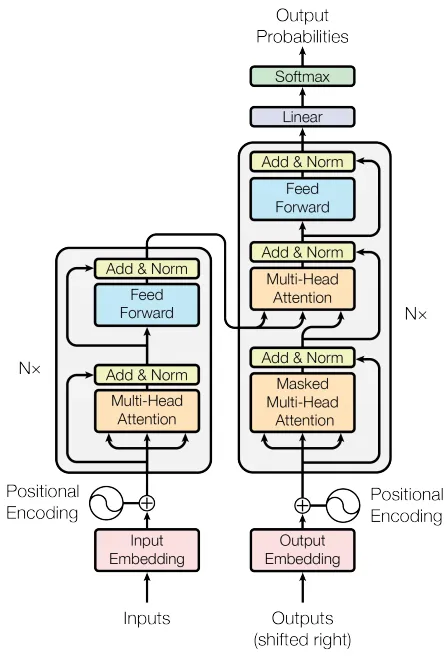

### Key Characteristics of Transformers:

1. **Self-Attention Mechanism**:

   * The core innovation of the transformer is the **self-attention** mechanism, which allows the model to weigh the importance of different words (or tokens) in a sequence relative to each other.
   * For example, in the sentence "The cat sat on the mat," the model can understand that "cat" is more relevant to "sat" than "mat" is.

2. **Parallelization**:

   * Unlike RNNs (recurrent neural networks), transformers process all tokens in a sequence **simultaneously**, not sequentially. This leads to much faster training times and better scalability.

3. **Layered Architecture**:

   * Transformers are composed of **stacked layers** that include:

     * Multi-head self-attention
     * Feed-forward neural networks
     * Layer normalization
     * Residual (skip) connections

4. **Positional Encoding**:

   * Since transformers don't have recurrence or convolution, they add **positional encodings** to input embeddings to retain information about the order of the tokens.

Source: https://arxiv.org/pdf/1706.03762

---

### Applications:

Transformers are the backbone of many state-of-the-art models, including:

* **BERT** (Bidirectional Encoder Representations from Transformers)
* **GPT** (Generative Pre-trained Transformer)
* **T5**, **XLNet**, **RoBERTa**, etc.

Beyond NLP, transformers are also used in:

* **Computer vision** (e.g., Vision Transformers or ViTs)
* **Audio processing**
* **Reinforcement learning** (e.g., Decision Transformers)

---

In [16]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import zipfile
from tqdm import tqdm
import os

zip_path = "/content/drive/MyDrive/datasets/MADAR-SHARED-TASK-final-release-25Jul2019.zip"
extract_to = "/content/MADAR/"

# Count the total number of files in the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())

    print(f"📦 Unzipping {total_files} files to {extract_to}...")

    with tqdm(total=total_files, unit="files") as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(member=file, path=extract_to)
            pbar.update(1)

print("✅ Unzip complete!")

📦 Unzipping 54 files to /content/MADAR/...


100%|██████████| 54/54 [00:00<00:00, 135.60files/s]

✅ Unzip complete!


In [18]:
import pandas as pd

# Replace with your file path
file_path = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-train.tsv"
file_path2 = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-dev.tsv"
file_path3 = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-test.tsv"

# Read TSV file into a DataFrame
train_df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'dialect'])
val_df = pd.read_csv(file_path2, sep='\t', header=None, names=['text', 'dialect'])
test_df = pd.read_csv(file_path3, sep='\t', header=None, names=['text', 'dialect'])

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_id'] = le.fit_transform(train_df['dialect'])  # Integers
# Save mapping if needed later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

val_df['label_id'] = val_df['dialect'].replace(label_mapping)
test_df['label_id'] = test_df['dialect'].replace(label_mapping)


print(label_mapping)  # e.g., {'MSA': 0, 'RIY': 1, 'BEI': 2, ...}

# print(train_df['label_id'])
# print(val_df['label_id'])
# print(test_df['label_id'])

{'ALE': np.int64(0), 'ALG': np.int64(1), 'ALX': np.int64(2), 'AMM': np.int64(3), 'ASW': np.int64(4), 'BAG': np.int64(5), 'BAS': np.int64(6), 'BEI': np.int64(7), 'BEN': np.int64(8), 'CAI': np.int64(9), 'DAM': np.int64(10), 'DOH': np.int64(11), 'FES': np.int64(12), 'JED': np.int64(13), 'JER': np.int64(14), 'KHA': np.int64(15), 'MOS': np.int64(16), 'MSA': np.int64(17), 'MUS': np.int64(18), 'RAB': np.int64(19), 'RIY': np.int64(20), 'SAL': np.int64(21), 'SAN': np.int64(22), 'SFX': np.int64(23), 'TRI': np.int64(24), 'TUN': np.int64(25)}


<ipython-input-19-a51a2b2ef640>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['label_id'] = val_df['dialect'].replace(label_mapping)
<ipython-input-19-a51a2b2ef640>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label_id'] = test_df['dialect'].replace(label_mapping)


#CAMeLBERT

A collection of 8 different BERT variant models trained on MSA, DA, and CA.

| Model                                | Variant      | Size  | #Word   |
|--------------------------------------|--------------|-------|---------|
| bert-base-arabic-camelbert-mix       | CA,DA,MSA    | 167GB | 17.3B   |
| bert-base-arabic-camelbert-ca        | CA           | 6GB   | 847M    |
| bert-base-arabic-camelbert-da        | DA           | 54GB  | 5.8B    |
| bert-base-arabic-camelbert-msa       | MSA          | 107GB | 12.6B   |
| bert-base-arabic-camelbert-msa-half  | MSA          | 53GB  | 6.3B    |
| bert-base-arabic-camelbert-msa-quarter | MSA        | 27GB  | 3.1B    |
| bert-base-arabic-camelbert-msa-eighth | MSA        | 14GB  | 1.6B    |
| bert-base-arabic-camelbert-msa-sixteenth | MSA     | 6GB   | 746M    |

This model claims to be made with the intention to be fine-tuned on NLP tasks such as NER, POS tagging, sentiment analysis, dialect identification, and poetry classification.

This model was trained and tested on a variety datasets included MADAR. They used F1 scores as a metric to compare results accross different datasets and while there are 26 classes, the F1-score did not seem high.

🔔 My objective for this notebook is to apply transfer learning on their model and acheive a higher F1-score.

| Dataset    | Variant | Mix   | CA    | DA    | MSA   | MSA-1/2 | MSA-1/4 | MSA-1/8 | MSA-1/16 |
|------------|---------|-------|-------|-------|-------|---------|---------|---------|----------|
| MADAR-26   | DA      | 62.9% | 61.9% | 61.8% | 62.6% | 62.0%   | 62.8%   | 62.0%   | 62.2%    |

---

⏰ I will first attempt to use their MSA-1/16 model for a couple reasons:
- This model is lightweight (uses less resources and runs quicker)
- This model performs at almost the same level compared to much more expensive versions of CAMeLBERT

# Preprocessing for CAMeLBERT

The model already includes a tokenizer that preprocesses for the model. In order not to disrupt previous learning from training on the base model, I'll feed raw data from datasets into this model and attempt not to augment any input data.

The model uses a WordPiece tokenizer trained directly on Arabic text (including dialectal and MSA). The authors of the model use a AutoTokenizer from Hugging Face and they list these included preprocessing steps:
- After extracting the raw text from each corpus, we apply the following pre-processing.
- We first remove invalid characters and normalize white spaces using the utilities provided by the original BERT implementation.
- We also remove lines without any Arabic characters.
- We then remove diacritics and kashida using CAMeL Tools.
- Finally, we split each line into sentences with a heuristics-based sentence segmenter.
- We train a WordPiece tokenizer on the entire dataset (167 GB text) with a vocabulary size of 30,000 using HuggingFace's tokenizers.
- We do not lowercase letters nor strip accents.

https://huggingface.co/CAMeL-Lab/bert-base-arabic-camelbert-mix

✏ Note: There is no Arabizi in the MADAR-26 dataset. If it possible to detect Arabic dialect from Arabizi text, I might be able to fine tune CAMeLBERT to detect dialects on Arabizi.

#Loading and testing CAMeLBERT

In [20]:
from transformers import AutoTokenizer, TFAutoModel

# Load the 1/16th CAMeLBERT model (MSA)
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)
sentence = "أنا أحب تعلم الذكاء الاصطناعي"
inputs = tokenizer(sentence, return_tensors="tf", padding=True, truncation=True)

# View tokenized IDs
print(inputs)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[    2,  3897,  7699,  3698, 15878, 23721,  2203,     3]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


## 🧠 Key Concept

### 🔹 The Base BERT Model

The base CAMeLBERT model:

* **Does not do classification by itself**
* Only outputs **embeddings**: numerical representations of tokens (including the `[CLS]` token)
* It has **no built-in softmax or labels** — it's like a feature extractor

In order to do classification (even testing it), you **do need a classifier head.**

Yes — you're absolutely right to be confused at first, and your intuition is spot on. Let me clarify everything step-by-step:

---

### 🅰️ Option 1: Just Test the Embeddings (No Training)

1. Extract the cls (class) embeddings from each sentence
2. Use those embeddings as features in a simple classifier like:

   * Logistic Regression
   * k-NN
   * SVM
3. Run classification with `sklearn` just to test how powerful the base model is

---

 ### 🅱️ Option 2: Build a Classification Head

* A full deep-learning model: BERT + classifier (usually a Dense layer)
* Train it end-to-end using TensorFlow or Keras
* Works well for preparing for a **fine-tuned final version**

---

We will go with Option 2 since the vast majority of state of the art models are deep neural networks.

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

model_name = "CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
from transformers import AutoTokenizer

texts = train_df['text'].tolist()

# Get token lengths for all sentences
lengths = [len(tokenizer.encode(text)) for text in texts]

# Key statistics
print(f"Max length: {max(lengths)}")
print(f"95th percentile: {np.percentile(lengths, 95)}")  # Helps avoid outliers
print(f"Mean length: {np.mean(lengths):.1f}")

Max length: 62
95th percentile: 20.0
Mean length: 11.4


We will choose a max token length to be 32 since it's a power of 2 and it covers the vast majority of our training data.

In [23]:
def df_to_dataset(df, tokenizer, max_length=128, batch_size=16):
    # Tokenize all text entries
    encodings = tokenizer(
        df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

    # Labels as tensor
    labels = tf.convert_to_tensor(df['label_id'].values, dtype=tf.int32)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [28]:
train_dataset = df_to_dataset(train_df, tokenizer).shuffle(1000)
val_dataset   = df_to_dataset(val_df, tokenizer)
test_dataset  = df_to_dataset(test_df, tokenizer)

In [29]:
from transformers import TFAutoModelForSequenceClassification, create_optimizer

# Your model
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=26
)

# Create optimizer with warmup
batch_size = 32
num_train_steps = len(train_df) // batch_size * 3  # 3 epochs
optimizer, _ = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

# Compile
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-msa-sixteenth and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
2600/2600 [==============================] - 405s 135ms/step - loss: 8.4651 - accuracy: 0.0574 - val_loss: 4.1167 - val_accuracy: 0.1133
Epoch 2/3
2600/2600 [==============================] - 340s 131ms/step - loss: 4.9230 - accuracy: 0.0542 - val_loss: 4.5422 - val_accuracy: 0.0460
Epoch 3/3
2600/2600 [==============================] - 338s 130ms/step - loss: 4.6158 - accuracy: 0.0436 - val_loss: 4.5422 - val_accuracy: 0.0460


In [31]:
model.evaluate(test_dataset)

325/325 [==============================] - 15s 46ms/step - loss: 4.5600 - accuracy: 0.0446


[4.559985637664795, 0.04461538419127464]

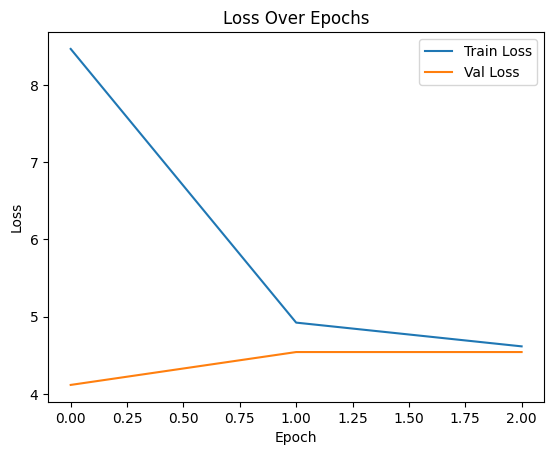

In [32]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Loading the base model with TFAutoModelForSequenceClassification yielded very low accuracy. It took 20 minutes to run 3 epochs as well. Fine tuning this model might be very tricky to do. Unless there is something very wrong with the way I am loading this model or loading the data, then this model might be very difficult to trian. The original makers of this model did say that they used a Google Cloud TPU (v3-8) and it took them 4.5 days to pretrain a model. I am using a T4 GPU.